#Overview

The objective of this code is to generate the sequence of signals (-1, 0, 1) that represent an investment strategy. Those signals are indicative of a recommendation to either decrease, maintain or increase portfolio allocations to equity.

The signals are the output classification of a random forest model that is trained to classify next-period S&P returns above, between or below a certain threshold. 

The inspiration of this model, and the features utilized come from the work of the hedge fund AHL of MAN Group. More information can be found on the webpage of their TargetRisk strategies.  

https://www.man.com/ahl-targetrisk

# Setup

In [ ]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from math import pi

In [ ]:
#utility function to calculate a zscore of a given time-series
def zscore(x, window = 104):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

## Load Raw Data for Features

### Bloomberg (Optional, will only run on a Bloomberg terminal)

In [ ]:
from xbbg import blp

ModuleNotFoundError: ignored

In [ ]:
startDate = '20100101'
endDate = '20201231' 

#### Bond Prices

In [ ]:
tr_ust = blp.bdh(tickers='BCEY4T Index', flds=['RT116'], start_date= startDate, end_date = endDate, Fill = 'P', Days = 'A')
tr_ust.columns = ['TR_UST']
tr_ust.to_csv('tr_ust.csv')

NameError: ignored

#### Equity Prices

In [ ]:
tr_spx = blp.bdh(tickers='SPX Index', flds=['RT116'], start_date= startDate, end_date = endDate, Fill = 'P', Days = 'A')
tr_spx.columns = ['TR_SPX']
tr_spx.to_csv('tr_spx.csv')

#### Volatility 

In [ ]:
vol_move = blp.bdh(tickers='MOVE Index', flds=['PX_LAST'], start_date = startDate, end_date = endDate, Fill = 'P', Days = 'A')
vol_move.columns = ['MOVE']
vol_move.to_csv('vol_move.csv')

In [ ]:
vol_vix = blp.bdh(tickers='VIX Index', flds=['PX_LAST'], start_date = startDate, end_date = endDate, Fill = 'P', Days = 'A')
vol_vix.columns = ['VIX']
vol_vix.to_csv('vol_vix.csv')

### Pre-loaded Files

In [ ]:
path = 'PATH_TO_DATA'

In [ ]:
#These features have been pre-loaded from Bloomberg onto CSV files
tr_ust = pd.read_csv(path + 'tr_ust.csv')
tr_ust.iloc[:,0] = pd.to_datetime(tr_ust.iloc[:,0], format = '%Y-%m-%d')
tr_ust = tr_ust.set_index('Unnamed: 0')
tr_spx = pd.read_csv(path + 'tr_spx.csv')
tr_spx.iloc[:,0] = pd.to_datetime(tr_spx.iloc[:,0], format = '%Y-%m-%d')
tr_spx = tr_spx.set_index('Unnamed: 0')
vol_move = pd.read_csv(path + 'vol_move.csv')
vol_move.iloc[:,0] = pd.to_datetime(vol_move.iloc[:,0], format = '%Y-%m-%d')
vol_move = vol_move.set_index('Unnamed: 0')
vol_vix = pd.read_csv(path + 'vol_vix.csv')
vol_vix.iloc[:,0] = pd.to_datetime(vol_vix.iloc[:,0], format = '%Y-%m-%d')
vol_vix = vol_vix.set_index('Unnamed: 0')

### Intraday Data

In [ ]:
intraday = pd.read_csv(path + 'intraday.csv')

In [ ]:
intraday.columns = ['DATE', 'CORR']
intraday['DATE'] = pd.to_datetime(intraday.DATE, format = '%Y%m%d')
intraday = intraday.set_index('DATE')

In [ ]:
intraday = pd.concat([tr_spx, intraday], axis = 1).ffill()[['CORR']]

## Feature Construction

### Equity Momentum

In [ ]:
#365-day zscore of 6mo total absolute return of S&P
mom_spx_score = zscore(tr_spx.TR_SPX/tr_spx.TR_SPX.shift(183) - 1, 365)
# 6mo total absolute return 
mom_spx_lvl = tr_spx.TR_SPX/tr_spx.TR_SPX.shift(183) - 1

### Bond Momentum

In [ ]:
#365-day zscore of 6mo total absolute return of 10yr treasury
mom_ust_score = zscore(tr_ust.TR_UST/tr_ust.TR_UST.shift(183) - 1, 365)
#6mo total absolute return of 10yr treasury
mom_ust_lvl = tr_ust.TR_UST/tr_ust.TR_UST.shift(183) - 1

### Equity-Bond Intraday Correlation

In [ ]:
#rolling 7-day maximum of intraday correlation
intraday_lvl = intraday.rolling(7).max()

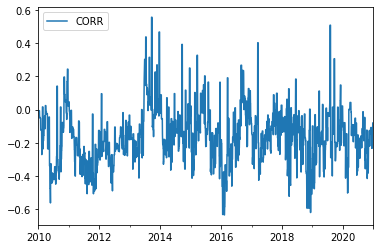

In [ ]:
intraday_lvl.plot()

### Bond Volatility

In [ ]:
# 7day change on the level of the MOVE index
vol_move_chng = vol_move.MOVE - vol_move.MOVE.shift(7)
# absolute level of the MOVE index
vol_move_lvl = vol_move.MOVE

### Equity Volatility

In [ ]:
# 7day change in the level of the MOVE index
vol_vix_chng = vol_vix.VIX - vol_vix.VIX.shift(7)
# absolute level of the VIX index
vol_vix_lvl = vol_vix.VIX

### Merge

In [ ]:
# merge into a single DataFrame of all the features
raw_signals = pd.concat([mom_spx_score, mom_spx_lvl, mom_ust_score, mom_ust_lvl, vol_move_chng, vol_move_lvl, vol_vix_chng, vol_vix_lvl, intraday_lvl], axis = 1)
raw_signals.columns = ['mom_spx_score', 'mom_spx_lvl', 'mom_ust_score', 'mom_ust_lvl', 'vol_move_lvl', 'vol_move_chng', 'vol_vix_chng', 'vol_vix_lvl', 'intraday_lvl']
raw_signals = raw_signals.fillna(method = 'ffill').fillna(0)
raw_signals.index = pd.to_datetime(raw_signals.index, format = '%Y-%m-%d')

## Label Construction

See detailed explanation of feature construction on 'SupervisedModel1.ipynb' code, as it follows a similar procedure. 

In [ ]:
spx_fwd_returns_1d = (tr_spx.TR_SPX.shift(-1)/tr_spx.TR_SPX - 1)
ust_fwd_returns_1d = (tr_ust.TR_UST.shift(-1)/tr_ust.TR_UST - 1)
fwd_returns_1d = spx_fwd_returns_1d - ust_fwd_returns_1d
fwd_returns_1d.index = pd.to_datetime(fwd_returns_1d.index, format = '%Y-%m-%d')

In [ ]:
labels_pos = fwd_returns_1d.rolling(7).aggregate(lambda x: x.cumsum().max()).shift(-7) > 0.015
labels_pos = labels_pos.resample('W').pad()

labels_neg = fwd_returns_1d.rolling(7).aggregate(lambda x: x.cumsum().min()).shift(-7) < -0.015
labels_neg = labels_neg.resample('W').pad()

labels_pos_idx = fwd_returns_1d.rolling(7).aggregate(lambda x: int((x.cumsum()).idxmax().strftime('%Y%m%d'))).shift(-7)
labels_pos_idx = labels_pos_idx.resample('W').pad()
labels_neg_idx = fwd_returns_1d.rolling(7).aggregate(lambda x: int(((-x).cumsum()).idxmax().strftime('%Y%m%d'))).shift(-7)
labels_neg_idx = labels_neg_idx.resample('W').pad()

up_first = labels_neg_idx[labels_neg & labels_pos] > labels_pos_idx[labels_neg & labels_pos]
both_correction = 1*up_first + -1*~up_first

labels_tot = -1*labels_neg + 1*labels_pos
labels_tot.loc[both_correction.index] = both_correction

labels_tot.name = 'labels'
labels_1wk = labels_tot.loc['2010-01-01':'2016-06-30']

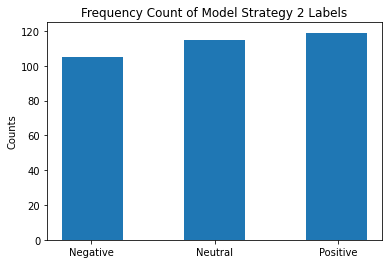

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

n, bins, patches = plt.hist(labels_1wk, 3, rwidth = 0.5, label = [-1, 0, 1])

plt.xticks([-0.675, 0, 0.675], ["Negative", "Neutral", "Positive"])
plt.title('Frequency Count of Model Strategy 2 Labels')
plt.ylabel('Counts');

In [ ]:
signals = raw_signals.loc['2010-01-01':'2016-06-24']
signals = signals.resample('W').pad()

# Model

In [ ]:
# Random Forest classifier with mostly default parameters
# only max_depth = 4, and n_estimators were changed

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', 
                              max_depth=4, max_features='auto', max_leaf_nodes=None,
                              min_impurity_decrease=0.0, 
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
                              oob_score=False, random_state=0, verbose=0, warm_start=False)
clf.fit(signals, labels_1wk)
print(clf.feature_importances_)

[0.08776569 0.13157073 0.06093805 0.07893958 0.05891344 0.10496859
 0.11333712 0.2270526  0.1365142 ]


In [ ]:
# in sample accuracy metrics calculated

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 

test = clf.predict(signals)
print(confusion_matrix(labels_1wk,test))
print(classification_report(labels_1wk,test))  
print(accuracy_score(labels_1wk,test))

[[ 56  36  13]
 [  5 102   8]
 [  2  26  91]]
              precision    recall  f1-score   support

          -1       0.89      0.53      0.67       105
           0       0.62      0.89      0.73       115
           1       0.81      0.76      0.79       119

    accuracy                           0.73       339
   macro avg       0.77      0.73      0.73       339
weighted avg       0.77      0.73      0.73       339

0.7345132743362832


In [ ]:
# in sample accuracy metrics calculated

signals = raw_signals.loc['2016-06-30':]
signals = signals.resample('W').pad()

test = clf.predict(signals)
test_prob = clf.predict_proba(signals)
test_prob = pd.DataFrame.from_dict(dict(zip(signals.index, test_prob)), orient = 'index')
test_prob.columns = ['neg', 'neu', 'pos']

In [ ]:
labels_1wk_test = labels_tot.loc['2016-06-30':]
print(confusion_matrix(labels_1wk_test,test))
print(classification_report(labels_1wk_test,test))  
print(accuracy_score(labels_1wk_test,test))

[[ 9 21 22]
 [ 3 78 31]
 [10 22 40]]
              precision    recall  f1-score   support

          -1       0.41      0.17      0.24        52
           0       0.64      0.70      0.67       112
           1       0.43      0.56      0.48        72

    accuracy                           0.54       236
   macro avg       0.49      0.48      0.47       236
weighted avg       0.53      0.54      0.52       236

0.538135593220339


# Output Charts

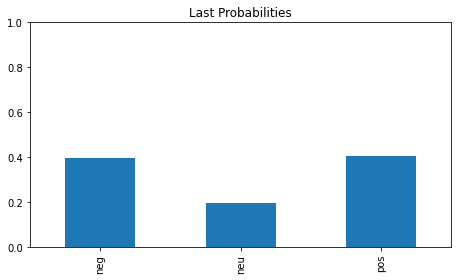

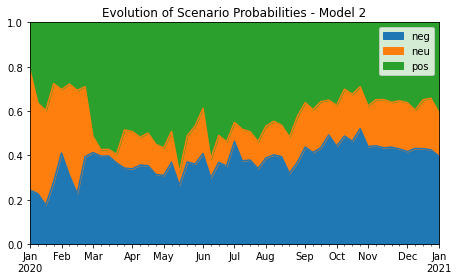

In [ ]:
# Evolution of Probabilities and Last Probability Graphs

fig00, ax00 = plt.subplots(1,1, figsize=(6.47,4))
test_prob.iloc[-1].plot.bar(ax = ax00, title = f'Last Probabilities')
plt.ylim(0,1)
plt.tight_layout()

fig0, ax0 = plt.subplots(1,1, figsize=(6.47,4))
title = 'Evolution of Scenario Probabilities - Model 2'
test_prob.loc['2020':].plot.area(ax=ax0, title=title)

plt.ylim(0,1)
plt.tight_layout()

# Strategy Output

Output for testing period saved in a separate file to load up on the MAB code

In [ ]:
signals = raw_signals.loc['2016-06-30':]
signals = signals.resample('W-FRI').pad()

model_output = clf.predict(signals)

In [ ]:
recommendation = pd.DataFrame.from_dict(dict(zip(signals.index, model_output)), orient = 'index')
recommendation.columns = ['signal']

In [ ]:
recommendation.to_csv('/content/drive/Shareddrives/Capstone Project/Data/supervisedmodel2.csv', sep='\t', encoding='utf-8', index=True)